# Kaggle GI Tract Inference Testing

Using code snippets from:
https://www.kaggle.com/code/yiheng/3d-solution-with-monai-produce-3d-data/notebook
https://www.kaggle.com/code/israrahmed919/createmasksopencv
https://www.kaggle.com/code/clemchris/gi-seg-pytorch-train-infer


This notebook was used to test the Inference approach to make sure it corresponds to the training approach and produces a run length encoded mask that is faithful to the ground truth mask

**Here is the sequence of operations for inference**

1. In training the run length encoded string representing the mask is decoded to mask image of same size as MRI slice.  Inference needs the same step.
2. In training the mask image is cropped to make consistent across all image aspect ratios found in the training data. Results in a (266x266) mask image. Inference needs the same step.
3. In training the mask image resize up to a multiple of 32 for the UUNet NN so to (288,288) (next size up.) Inference needs the same step.
4. In inference we take a mask image predicted by the NN.  To test we will take the mask image from step 3 above (use training data to test our inference process)
5. In inference we need to take our mask image and go back to original size and aspect ratio of the input MRI image.  So we resize down to (266x266) and pad with zeros to get the right aspect ratio.
6. In inference we need to encode the image mask from step 5 into a strings (one per organ) that are Run Length Encoded.  These are submitted.

**For measuring fidelity**
We could use the RLE strings, but its hard to compare them.  Instead we compare images using the Dice metric.  This lets us understand the degradation to our predictions due to image resizing.
1. We take the RLE strings from Step 6 above and run through the same processing used in training to produce the mask image of (266x266).  This is what Kaggle will be doing to mesure the eval metrics.
7. To test fidelity of these steps, we calculate the Dice score between the image from Step 3 and the above step.

Results:

* threshold = 0.8
    * Baseline Dice 0.9711 for bilinear interp on image resizing
    * trial 1 Dice .9883 for bilinear on resize up and bicubic for resize down
    * trial 2 Dice .9996 for bicubic on resize up and bicubic for resize down
    * trial 3 Dice .9686 for bilinear up and down, but using antialiasing up and down
* threshold = 0.5
    * trial 4 Dice .9997 for same settings as baseline (bilinear interp on image resizing)
    
So we have 2 options, using a lower threshold or use bicubic.  We use bicubic since it less sensitive to threshold.  Output of the NN is dependent on estimated probability so this is a better option.

Consider: two stages of thresholding - one on the output of the NN and another on the resized+padded image?  Gains may not be that significant - but does not affect training so easy to try.

Consider: Padding the training images to the larger size 360x360.  Then crop at inference.




In [1]:
import os, glob
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import torch
from PIL import Image
from einops import rearrange, reduce, repeat
import segmentation_models_pytorch as smp
from tqdm import tqdm




ROOT_FOLDER = '/media/SSD/gi-tract/uw-madison-gi-tract-image-segmentation/'
MODEL_FOLDER = '/media/SSD/gi-tract/uw-madison-gi-tract-image-segmentation/kaggle models'
model_name_base = 'Unet-1'
model_training_level = '1'

DEVICE = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
#DEVICE = "cpu"
#DEVICE = "cuda:0"

# Data

## Process the Test files

In [2]:
debug = True

In [3]:
if debug:  # Use the training files as input
    test_fnames = glob.glob("{}train/*/*/scans/*.png".format(ROOT_FOLDER))
else:  # Use the test files as input
    test_fnames = glob.glob("{}test/*/*/scans/*.png".format(ROOT_FOLDER))

In [4]:

file_df = pd.DataFrame(test_fnames)

In [5]:
file_df.columns = ["path"]

In [6]:
def id_from_path(p):
    
    #p = '/media/SSD/gi-tract/uw-madison-gi-tract-image-segmentation/train/case24/case24_day25/scans/slice_0046_266_266_1.50_1.50.png'
    s1 = p.split('/')
    filename = s1[-1] # 'slice_0046_266_266_1.50_1.50.png'
    case_day_str = s1[-3] # 'case24_day25'
    slice_str = '_'.join(filename.split('_')[-7:-4]) #'slice_0046'
    id_str = case_day_str + '_' + slice_str #'case24_day25_slice_0046'
    return id_str
    
    

In [7]:
file_df["id"] = file_df["path"].apply(id_from_path)

In [8]:
file_df

,path,id
0,/media/SSD/gi-tract/uw-madison-gi-tract-image-...,case24_day25_slice_0046
1,/media/SSD/gi-tract/uw-madison-gi-tract-image-...,case24_day25_slice_0099
2,/media/SSD/gi-tract/uw-madison-gi-tract-image-...,case24_day25_slice_0013
3,/media/SSD/gi-tract/uw-madison-gi-tract-image-...,case24_day25_slice_0064
4,/media/SSD/gi-tract/uw-madison-gi-tract-image-...,case24_day25_slice_0090
...,...,...
38491,/media/SSD/gi-tract/uw-madison-gi-tract-image-...,case29_day0_slice_0049
38492,/media/SSD/gi-tract/uw-madison-gi-tract-image-...,case29_day0_slice_0079
38493,/media/SSD/gi-tract/uw-madison-gi-tract-image-...,case29_day0_slice_0093
38494,/media/SSD/gi-tract/uw-madison-gi-tract-image-...,case29_day0_slice_0119


In [9]:
sub_df = pd.read_csv(ROOT_FOLDER+'/sample_submission.csv')

In [10]:
sub_df.columns

Index(['id', 'class', 'predicted'], dtype='object')

## Create a special Pytorch Dataset for this testing

In [11]:
from torchvision.transforms import PILToTensor

In [12]:
from torchvision import transforms
from torch.nn import functional as F

In [13]:
# ref.: https://www.kaggle.com/stainsby/fast-tested-rle
def rle_encode(img):
    """ TBD
    
    Args:
        img (np.array): 
            - 1 indicating mask
            - 0 indicating background
    
    Returns: 
        run length as string formated
    """
    
    pixels = img.flatten()
    pixels = np.concatenate([[0], pixels, [0]])
    runs = np.where(pixels[1:] != pixels[:-1])[0] + 1
    runs[1::2] -= runs[::2]
    return ' '.join(str(x) for x in runs)

## Test the Inference processing

For each training mask:
1. Do run length decoding to turn string for organ into mask image ( organ on each channel)
2. Check that mask image registers on the input image correctly (rotation and pixels)
3. Transform mask image using the training transform (center crop to 266x266 and then resize to 288x288)
4. Transform the mask image using the inverse (resize to 266x266 then pad back on all sides to match orig size)
5. Do run length encoding to turn into a string for each channel
6. Check that organ strings out == organ strings in

Run training data loader to get a batch - in order
Run test data loader to get the same batch - in order

Modify the training data loader to add the test data loader code
then do 4,5,6


In [14]:
#A version of the training dataset for testing the transforms and RLE
class Dataset_from_df(torch.utils.data.Dataset):
    def __init__(self, df, path, transform=None):
        self.df = df
        self.path = path
        self.transform = transform
        self.pil_to_tensor = PILToTensor()

        
    def __len__(self):
        return self.df.shape[0]
    
    #Helper Function to decode RLE
    def _rle_decode_float(self,mask_rle, shape, color_val=1):
        '''
        mask_rle: run-length as string formated (start length)
        shape: (height,width) of array to return 
        Returns numpy array, color_val - mask, 0 - background

        '''
        s = mask_rle.split()
        starts, lengths = [np.asarray(x, dtype=int) for x in (s[0:][::2], s[1:][::2])]
        starts -= 1
        ends = starts + lengths
        #img = np.zeros((shape[0] * shape[1], shape[2]), dtype=np.float32)

        img = torch.zeros(shape[1]*shape[2])
        for lo, hi in zip(starts, ends):
            img[lo : hi] = color_val
        return img.reshape(shape)    
    
    
    def __getitem__(self, idx):
        row = self.df.iloc[idx]
        
        
        img_path = self.path/row.subpath
        # Use PIL Image to read the image files since it handles 32 bit images
        img = self.pil_to_tensor(Image.open(img_path))
        #print(img_path)
        #print(img.shape)
        
        mask_shape = img.shape # From inference dl
        
        lb_class_seg = row.large_bowel
        sb_class_seg = row.small_bowel
        st_class_seg = row.stomach
        
        
        mask = torch.zeros((3, img.shape[1], img.shape[2]))

        if type(lb_class_seg) is str:
            mask[0,:,:] = self._rle_decode_float(lb_class_seg,mask_shape,color_val=1)

        if type(sb_class_seg) is str:
            mask[1,:,:] = self._rle_decode_float(sb_class_seg, mask_shape,color_val=1)

        if type(st_class_seg) is str:
            mask[2,:,:] = self._rle_decode_float(st_class_seg, mask_shape,color_val=1)
        
        
        
        if self.transform:
            img = self.transform(img)
            mask = self.transform(mask)
    
        
        
        return {
            "image": img,
            "mask": mask,
            "mask_shape":mask_shape,  # from inference dl
            "id":row.id, # from inference dl
            "ms0":row.large_bowel,
            "ms1":row.small_bowel,
            "ms2":row.stomach
            
        }

In [15]:
def rle_decode_float(mask_rle, shape, color_val=1):
    '''
    mask_rle: run-length as string formated (start length)
    shape: (height,width) of array to return 
    Returns numpy array, color_val - mask, 0 - background

    '''
    s = mask_rle.split()
    starts, lengths = [np.asarray(x, dtype=int) for x in (s[0:][::2], s[1:][::2])]
    starts -= 1
    ends = starts + lengths
    #img = np.zeros((shape[0] * shape[1], shape[2]), dtype=np.float32)

    img = torch.zeros(shape[1]*shape[2])
    for lo, hi in zip(starts, ends):
        img[lo : hi] = color_val
    return img.reshape(shape)    

In [16]:
img = torch.zeros(266*266)

In [17]:
img.reshape((1,266,266))

tensor([[[0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.],
         ...,
         [0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.]]])

In [18]:
df2d = pd.read_csv(ROOT_FOLDER + "df2d_metadata.csv").fillna('')

In [19]:
from pathlib import Path

In [20]:
test_transforms = transforms.Compose(
    [transforms.CenterCrop((266,266),),
    transforms.ConvertImageDtype(torch.float32),
    transforms.Resize((288,288),interpolation=transforms.InterpolationMode.BICUBIC)])  # multiple of 32 for UUnet

#,interpolation=transforms.InterpolationMode.BICUBIC

In [21]:
test_dataset = Dataset_from_df(df2d[df2d['segmentations']],Path(ROOT_FOLDER)/'train',test_transforms)

In [22]:
test_dataset[0]

{'image': tensor([[[ 0.0000e+00,  0.0000e+00,  0.0000e+00,  ...,  0.0000e+00,
            0.0000e+00,  0.0000e+00],
          [ 0.0000e+00,  0.0000e+00,  0.0000e+00,  ...,  0.0000e+00,
            0.0000e+00,  0.0000e+00],
          [ 0.0000e+00,  0.0000e+00,  0.0000e+00,  ...,  0.0000e+00,
            0.0000e+00,  0.0000e+00],
          ...,
          [ 0.0000e+00, -3.1372e-11,  3.8785e-10,  ...,  0.0000e+00,
            0.0000e+00,  0.0000e+00],
          [ 0.0000e+00, -3.1372e-11,  3.8785e-10,  ...,  0.0000e+00,
            0.0000e+00,  0.0000e+00],
          [ 0.0000e+00, -3.1372e-11,  3.8785e-10,  ...,  0.0000e+00,
            0.0000e+00,  0.0000e+00]]]),
 'mask': tensor([[[0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.],
          ...,
          [0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.]],
 
         [[0., 0., 0.,  ..., 0., 0., 0.],
          [

In [23]:
test_dataloader = torch.utils.data.DataLoader(dataset=test_dataset,
                                               batch_size=16,
                                               num_workers=2,
                                               pin_memory=True,
                                               shuffle=False)

In [24]:
def dice_coef(y_true, y_pred, thr=0.5, dim=(2,3), epsilon=0.001):
    y_true = y_true.to(torch.float32)
    y_pred = (y_pred>thr).to(torch.float32)
    inter = (y_true*y_pred).sum(dim=dim)
    den = y_true.sum(dim=dim) + y_pred.sum(dim=dim)
    dice = ((2*inter+epsilon)/(den+epsilon)).mean(dim=(1,0))
    return dice

In [25]:
def plot_data(d1,d2):
    ratio = 1.0
    plt.figure(figsize=(20,20))
    plt.subplot(1,2,1)
    plt.imshow(rearrange(d1.squeeze().numpy(),'c h w -> h w c'), aspect=ratio)
    plt.title(f"Image 1 Shape= {d1.shape}")
    plt.axis('off')
    plt.subplot(1,2,2)
    plt.imshow(rearrange(d2.squeeze().numpy(),'c h w -> h w c'), aspect=ratio)
    plt.title(f"Image 2 Shape = {d2.shape}")
    plt.axis('off')

In [26]:
threshold = .8

In [28]:
sub = {'id':[], 'class':[], 'predicted':[]}
pbar = tqdm(total=len(test_dataloader))
metric = 0


for batch in test_dataloader:
    
    images = batch['image'].to(DEVICE)
    mask_shape = batch['mask_shape']
    idx = batch['id']
    ms0 = batch['ms0'] # RLE truth
    ms1 = batch['ms1'] # RLE truth
    ms2 = batch['ms2'] # RLE truth
    
    masks = batch['mask'].to(DEVICE) #image mask from training data
    

    #with torch.no_grad():
    #    output = models[0](images)
    #    output = torch.nn.Sigmoid()(output)/n_folds
    #    mask = output
    #    for i in range(1,n_folds):
    #        output = models[i](images)
    #        output = torch.nn.Sigmoid()(output)/n_folds
    #        mask = mask + output
    
    #print("1", mask.shape, masks.shape)

    mask = masks # switcheraoo so that the training ground truth mask image is fed to the below

    #From here we need to apply the invert of the the basic image crop and resize exactly to the mask image
    #and then apply run length encoding to that image
    
    mask = transforms.Resize((266,266),interpolation=transforms.InterpolationMode.BICUBIC)(mask) # undo resize to 288x288
    #,interpolation=transforms.InterpolationMode.BICUBIC
    #print("3", mask.shape)
    
    #print(4,mask_shape)
    
    a0 = torch.div(mask_shape[1] - 266,2,rounding_mode = 'floor') # (mask_shape[1] - 266)//2
    a1 = torch.div(mask_shape[2] - 266,2,rounding_mode = 'floor')
    #print(a0,a1)
    
    # Since we are processing a batch, the final mask shape may change within a batch
    # So we can't store that as a 1 tensor per batch
    # Need to process each batch item individually from here

    #single_mask = torch.zeros_like(mask[0])
    batch_size = mask.shape[0]
    for b in range(0,batch_size):
        single_mask = F.pad(mask[b],(a1[b], a1[b], a0[b], a0[b]),  "constant", 0)
        #print("5", single_mask.shape)
        if (single_mask.shape[1] != mask_shape[1][b]) or (single_mask.shape[2] != mask_shape[2][b]):
            print("mask in:",mask[b].shape)
            print("mismatch:",mask_shape[1][b],mask_shape[2][b], single_mask.shape)
        single_mask = (single_mask > threshold)*1.0
        single_mask = single_mask.cpu().detach().numpy()

        large_bowel = rle_encode(single_mask[0])
        sub['id'].append(idx)
        sub['class'].append('large_bowel')
        sub['predicted'].append(large_bowel)

        small_bowel = rle_encode(single_mask[1])
        sub['id'].append(idx)
        sub['class'].append('small_bowel')
        sub['predicted'].append(small_bowel)

        stomach = rle_encode(single_mask[2])
        sub['id'].append(idx)
        sub['class'].append('stomach')
        sub['predicted'].append(stomach)    

    
        #print("0T>",ms0[b])
        #print("0P>",large_bowel)
        
        #print("1T>",ms1[b])
        #print("1P>",small_bowel)
        
        #print("2T>",ms2[b])
        #print("2P>",stomach)
        
        lb_class_seg = ms0[b]
        sb_class_seg = ms1[b]
        st_class_seg = ms2[b]
        
        
        maskGT = torch.zeros((3, mask_shape[1][b], mask_shape[2][b]))
        shape2d = maskGT.shape
        shape2d = (1, shape2d[1], shape2d[2])
        #print(shape2d)

        if type(lb_class_seg) is str:
            maskGT[0,:,:] = rle_decode_float(lb_class_seg,shape2d,color_val=1)


        if type(sb_class_seg) is str:
            maskGT[1,:,:] = rle_decode_float(sb_class_seg, shape2d,color_val=1)

        if type(st_class_seg) is str:
            maskGT[2,:,:] = rle_decode_float(st_class_seg, shape2d,color_val=1)
        
        #print(maskGT.shape, torch.tensor(single_mask).shape)
        #print(dice_coef(maskGT.unsqueeze(0),torch.tensor(single_mask).unsqueeze(0)))
        metric += dice_coef(maskGT.unsqueeze(0),torch.tensor(single_mask).unsqueeze(0))
        
        #plot_data(maskGT,torch.tensor(single_mask))
        
    pbar.update(1)
    #break
pbar.close()
torch.cuda.empty_cache()

metric /= len(test_dataloader.dataset)

print("metric = ",metric)



  0%|                                                  | 0/1037 [01:06<?, ?it/s]

 19%|███████▍                                | 192/1037 [00:15<01:05, 12.84it/s]


 37%|██████████████▉                         | 386/1037 [00:30<00:52, 12.51it/s]


 56%|██████████████████████▎                 | 580/1037 [00:45<00:32, 13.91it/s]


 75%|█████████████████████████████▊          | 774/1037 [00:59<00:21, 12.06it/s]


 93%|█████████████████████████████████████▎  | 968/1037 [01:14<00:05, 12.59it/s]


100%|███████████████████████████████████████| 1037/1037 [01:20<00:00, 12.94it/s]

metric =  tensor(0.9996)


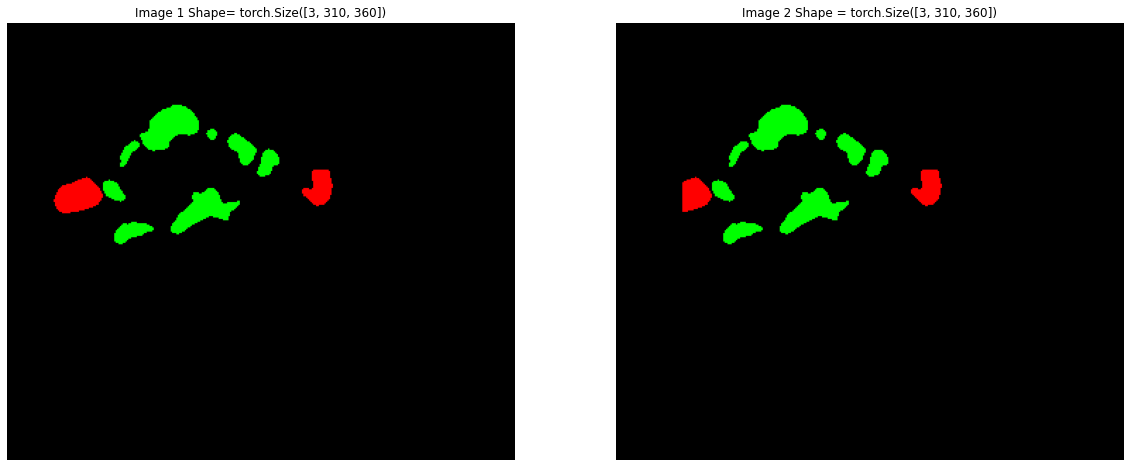

In [29]:
plot_data(maskGT,torch.tensor(single_mask))